# 0.0. IMPORTS

In [ ]:
! pip install scikit-learn==0.22
! pip install imblearn --upgrade
! pip install sklearn --upgrade


In [96]:
import re
import numpy                as np
import pandas               as pd
import seaborn              as sns
import matplotlib.pyplot    as plt
import xgboost              as xgb

from IPython.core.display       import HTML
from IPython.display            import Image
from boruta                     import BorutaPy
from tabulate                   import tabulate
from sklearn.metrics            import f1_score
from sklearn.model_selection    import GridSearchCV
from sklearn.model_selection    import cross_val_score
from sklearn.model_selection    import train_test_split
from sklearn.ensemble           import VotingClassifier
from sklearn.ensemble           import AdaBoostClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.ensemble           import RandomForestRegressor
from sklearn.ensemble           import RandomForestClassifier
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder


## 0.1. HELPER FUNCTIONS

In [4]:
# ===================================================================
# Configura os gráficos
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    # configura o pandas para quantidade de casas decimeis
    # pd.set_option('display.float_format', lambda x: '%.20f' % x)

    # Alterar posteriormente
    import warnings
    warnings.filterwarnings('ignore')

    sns.set()
    
jupyter_settings()

## 0.2. LOADING DATA

In [5]:
path_data = "../data/"

In [6]:
df_train_raw = pd.read_csv(path_data + "train.csv", low_memory=False)
df_test_raw = pd.read_csv(path_data + "test.csv", low_memory=False)

# 1.0. PASSO 1 - DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_train_raw.copy()

In [8]:
df1.sample(2)

country  year       uniqueid location_type cellphone_access  household_size  age_of_respondent gender_of_respondent relationship_with_head           marital_status      education_level             job_type                     uid bank_account
8183     Kenya  2018  uniqueid_5244         Rural              Yes               4                 56                 Male      Head of Household  Married/Living together    Primary education  Farming and Fishing     Kenya_uniqueid_5244           No
4498  Tanzania  2017  uniqueid_5209         Urban               No               2                 56               Female                 Spouse     Single/Never Married  No formal education        Self employed  Tanzania_uniqueid_5209           No

## 1.1. Rename Columns

In [9]:
df1.columns

Index(['country', 'year', 'uniqueid', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type', 'uid', 'bank_account'],
      dtype='object')

In [10]:
df1.columns = ['country', 'year', 'id', 'location', 'phone',
       'family', 'age', 'sex',
       'relation', 'marital', 'education',
       'job', 'uid', 'bank_account']

## 1.2. Data Dimensions

In [11]:
print(f"Number of lines: {df1.shape[0]}")
print(f"Number of columns: {df1.shape[1]}")

Number of lines: 11762
Number of columns: 14


## 1.3. Data Types

In [12]:
df1.dtypes

country         object
year             int64
id              object
location        object
phone           object
family           int64
age              int64
sex             object
relation        object
marital         object
education       object
job             object
uid             object
bank_account    object
dtype: object

## 1.4. Check NA

In [13]:
df1.isna().sum()

country         0
year            0
id              0
location        0
phone           0
family          0
age             0
sex             0
relation        0
marital         0
education       0
job             0
uid             0
bank_account    0
dtype: int64

## 1.5. Fillout NA

## 1.6. Change Types

In [14]:
# Transformando a variável resposta em numérica
df1['bank_account'] = df1['bank_account'].apply(lambda x: 0 if x == 'No' else 1)

# Apagando as letras do uniqueid
df1['id'] = df1['id'].apply(lambda x: int(re.search('\d+',x).group(0)))
df1['id'] = df1['id'].astype('int64')

## 1.7. Descriptive Statistical

In [15]:
# Separando os atributos entre numéricos e categóricos
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [16]:
# Central tendency - mean, median
media = pd.DataFrame(numerical_attributes.apply(np.mean)).T
mediana = pd.DataFrame(numerical_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
dev_pad = pd.DataFrame(numerical_attributes.apply(np.std)).T
minimo = pd.DataFrame(numerical_attributes.apply(min)).T
maximo = pd.DataFrame(numerical_attributes.apply(max)).T
rang = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
metrics = pd.concat([minimo, maximo, rang, media, mediana, dev_pad, skew, kurtosis]).T.reset_index()
metrics.columns = ['attributes', 'minimo', 'maximo', 'rang', 'media', 'mediana', 'dev_pad', 'skew', 'kurtosis']

In [17]:
metrics

attributes  minimo  maximo    rang        media  mediana      dev_pad      skew  kurtosis
0          year  2016.0  2018.0     2.0  2016.983336   2017.0     0.848633  0.031654 -1.610921
1            id     2.0  8756.0  8754.0  3438.185088   3232.0  2265.777243  0.360197 -0.867348
2        family     1.0    21.0    20.0     3.793913      3.0     2.225328  1.004163  1.529882
3           age    16.0   100.0    84.0    38.602364     35.0    16.333929  0.851705  0.161847
4  bank_account     0.0     1.0     1.0     0.143258      0.0     0.350336  2.036832  2.149051

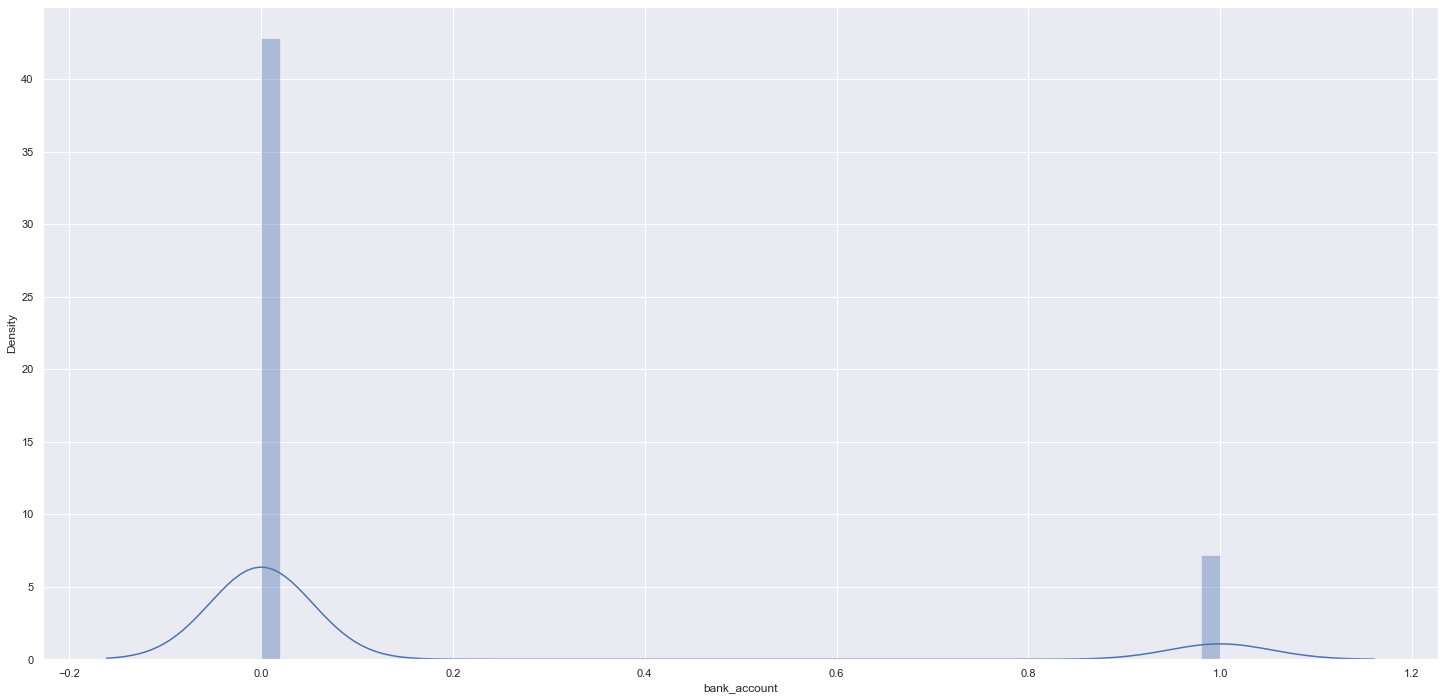

In [18]:
sns.distplot(df1['bank_account']);

### 1.7.2 Categorical Attributes

In [19]:
categorical_attributes.apply(lambda x: x.unique().shape[0])

country          4
location         2
phone            2
sex              2
relation         6
marital          5
education        6
job             10
uid          11762
dtype: int64

# 2.0. PASSO 2 - FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

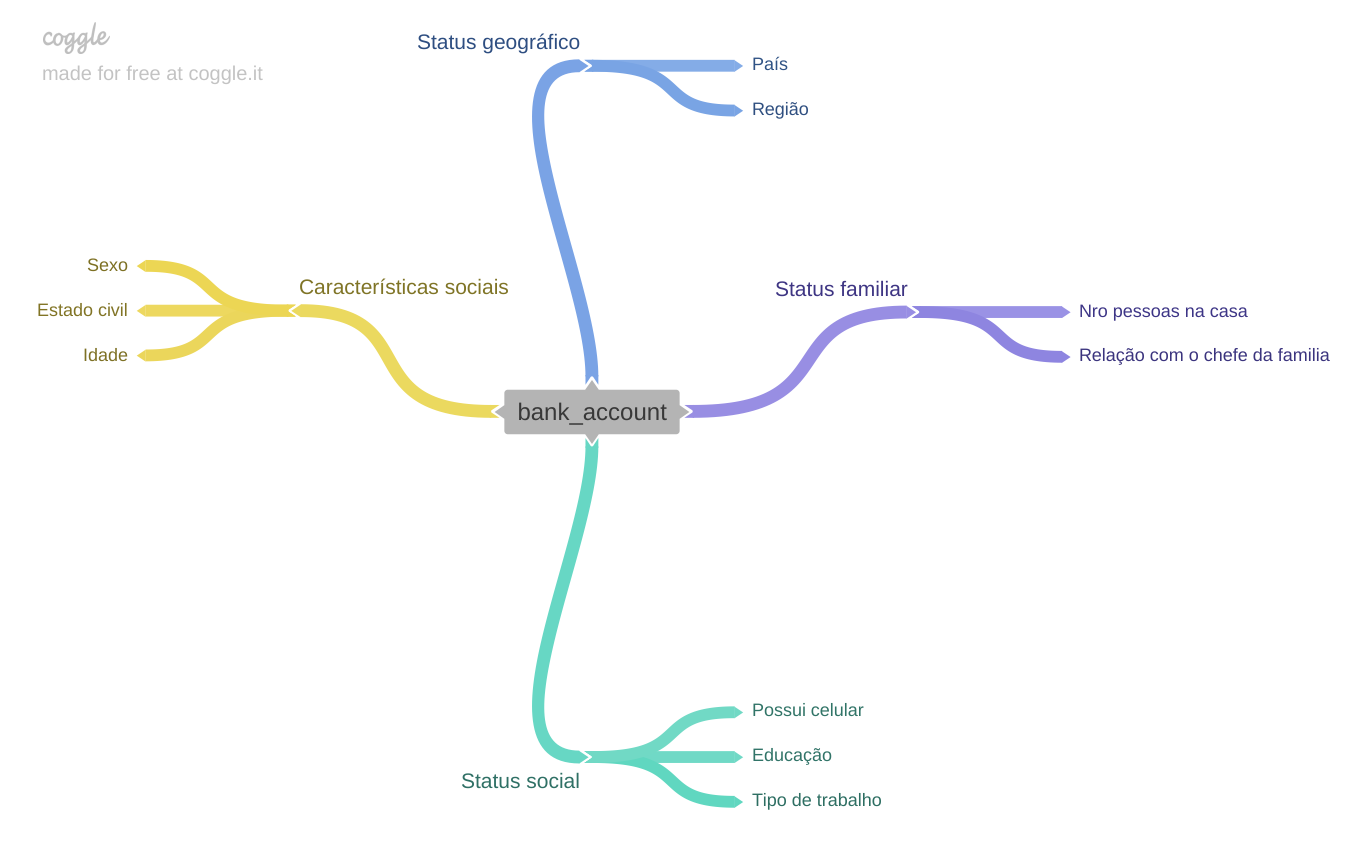

In [21]:
Image(path_data + 'bank_account.png')

## 2.2. Criação das Hipóteses

### 2.2.1. Dados Pessoais

#### 1. Homens abrem mais contas que as mulheres
#### 2. Casados abrem mais contas que outros estados civis
#### 3. Jovens abrem menos contas

### 2.2.2. Hipóteses Geográficas

#### 1. Moradores da área rural abrem menos contas
#### 2. Países com menor PIB tem menos abertura de contas
quenia 1169
tanzania 900
ruanda 765
uganda 666

### 2.2.3. Hipóteses Sociais

#### 1. Donos de celulares abrem mais contas
#### 2. Pessoas com maior instrução abrem mais contas
#### 3. Pessoas com melhores condiçoes de trabalho abrem mais contas

### 2.2.3. Hipóteses Familiares

#### 1. Chefes de familia abrem mais contas
#### 2. Filhos abrem menos contas
#### 3. Esposas abrem menos contas
#### 4. Pessoas de familias maiores abrem menos contas

## 2.3. Lista Final de Hipóteses

### 1. Homens abrem mais contas que as mulheres
### 2. Casados abrem mais contas que outros estados civis
### 3. Jovens abrem menos contas
### 4. Moradores da área rural abrem menos contas
### 5. Países com menor PIB tem menos abertura de contas
### 7. Donos de celulares abrem mais contas
### 8. Pessoas com maior instrução abrem mais contas
### 9. Pessoas com melhores condiçoes de trabalho abrem mais contas
### 10. Chefes de familia abrem mais contas
### 11. Filhos abrem menos contas
### 12. Esposas abrem menos contas
### 13. Pessoas de familias maiores abrem menos contas

## 2.4. Feature Engineering

In [22]:
# Derivar variáveis

# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [23]:
df3 = df2.copy()

## 3.1. Filtragem de linhas

In [24]:
# Apagar as linhas não desnecessárias
df3 = df3[df3['marital'] != 'Dont know']
df3 = df3[df3['education'] != 'Other/Dont know/RTA']
df3 = df3[df3['job'] != 'Dont Know/Refuse to answer']

## 3.2. Filtragem de colunas

In [25]:
# Apagar as colunas não utilizadas
df3.drop(columns=['uid'], inplace=True)

# 4.0. PASSO 4 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [26]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Variável Resposta

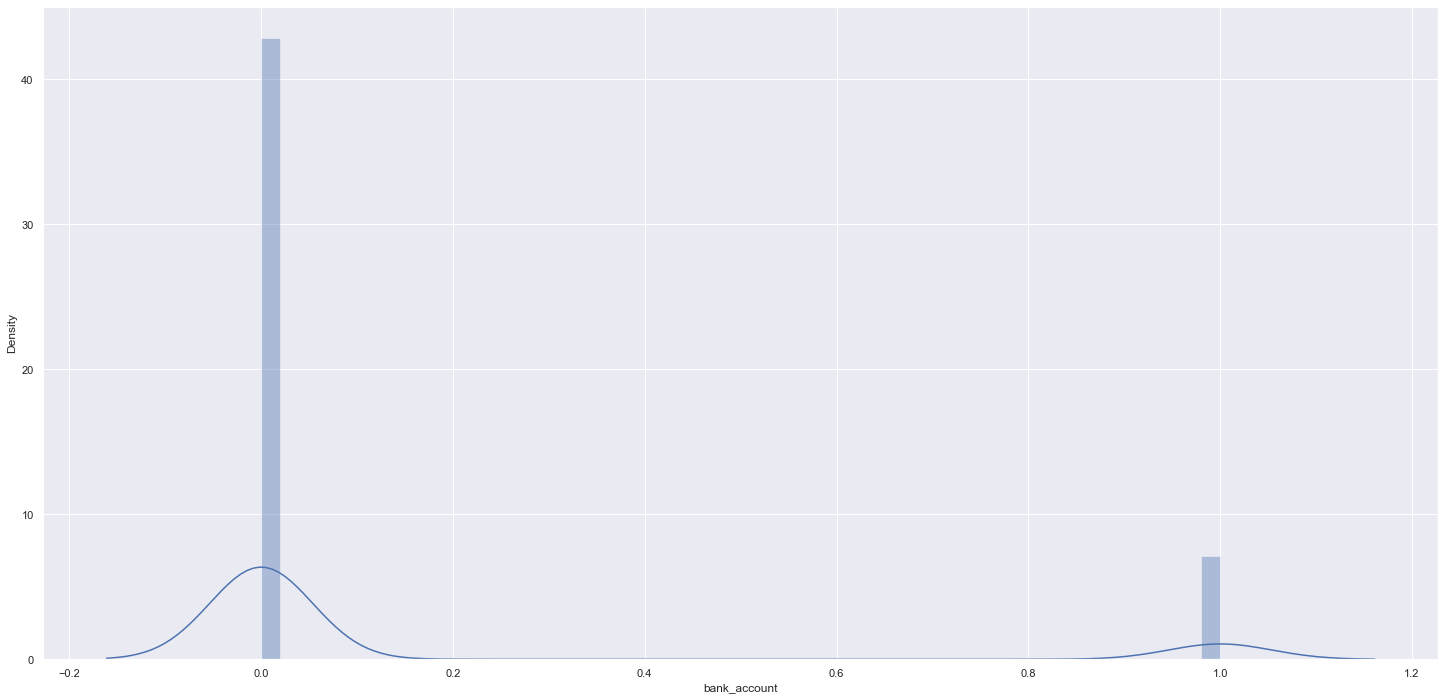

In [27]:
sns.distplot(df4['bank_account'], kde=True);

### 4.1.2. Variáveis Numéricas

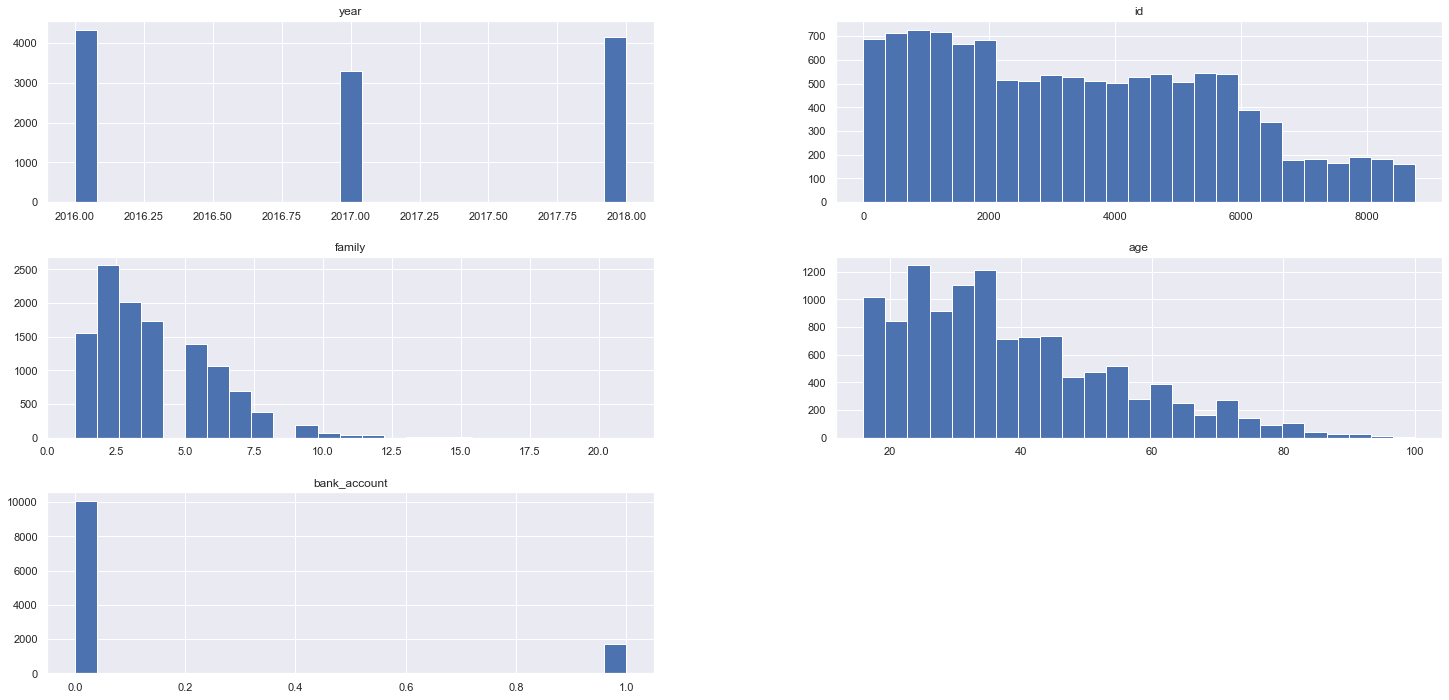

In [28]:
numerical_attributes.hist(bins=25);

### 4.1.3. Variáveis Categóricas

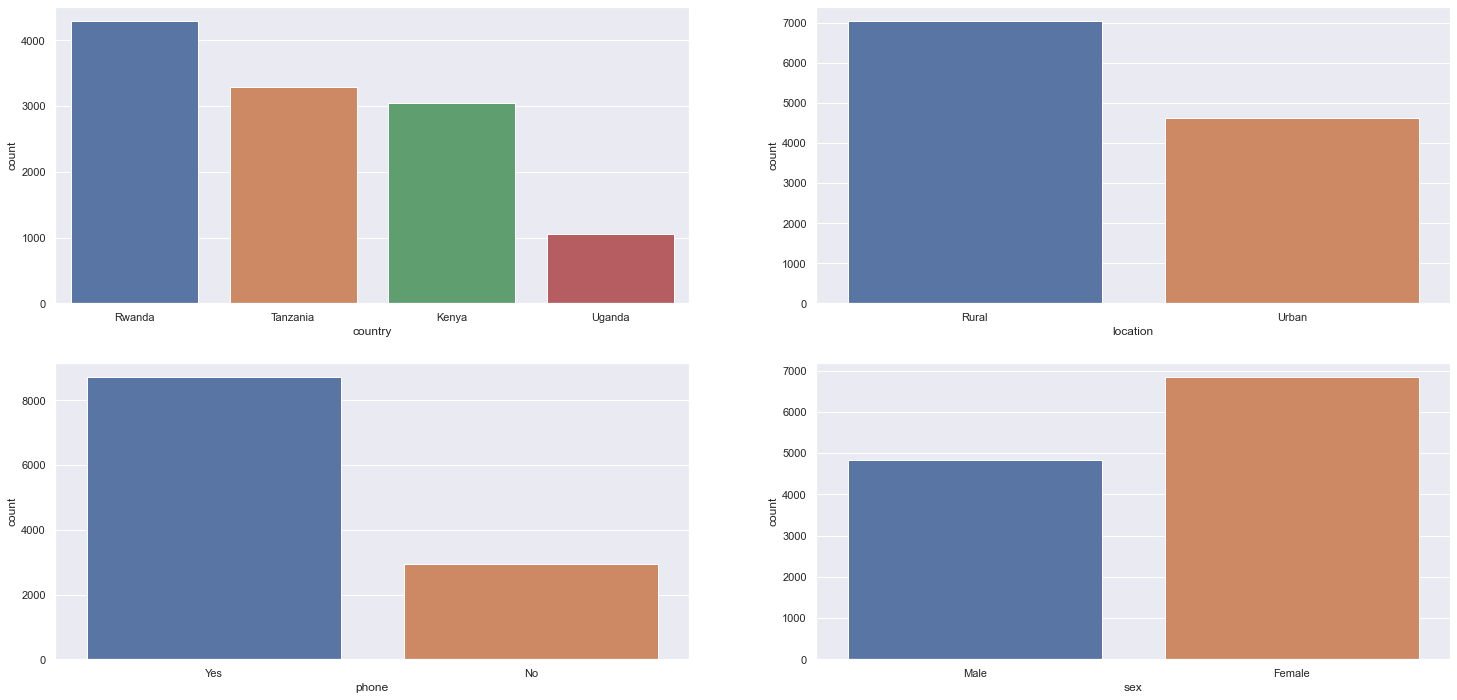

In [29]:
# Plotando as variáveis categóricas
plt.subplot(2,2,1)
sns.countplot(df4['country'])

plt.subplot(2,2,2)
sns.countplot(df4['location'])

plt.subplot(2,2,3)
sns.countplot(df4['phone'])

plt.subplot(2,2,4)
sns.countplot(df4['sex']);

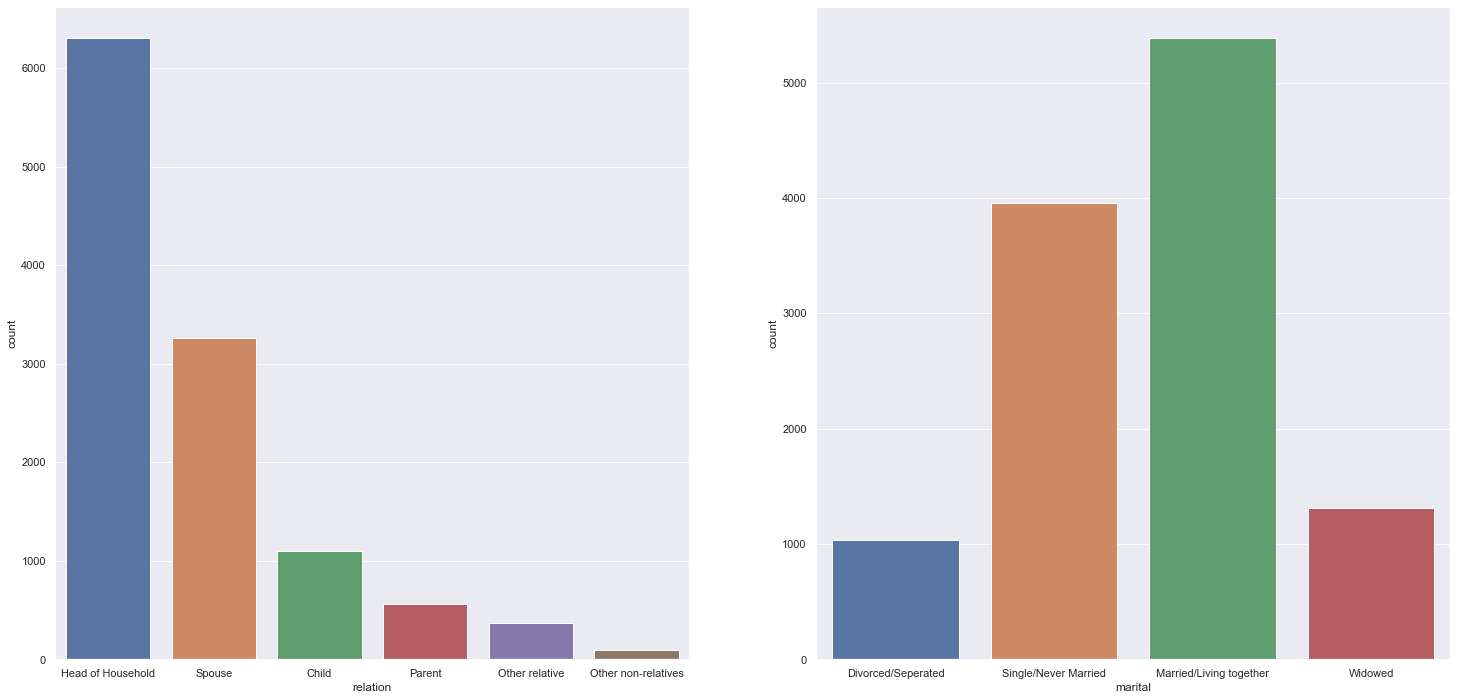

In [30]:
plt.subplot(1,2,1)
sns.countplot(df4['relation'])

plt.subplot(1,2,2)
sns.countplot(df4['marital']);

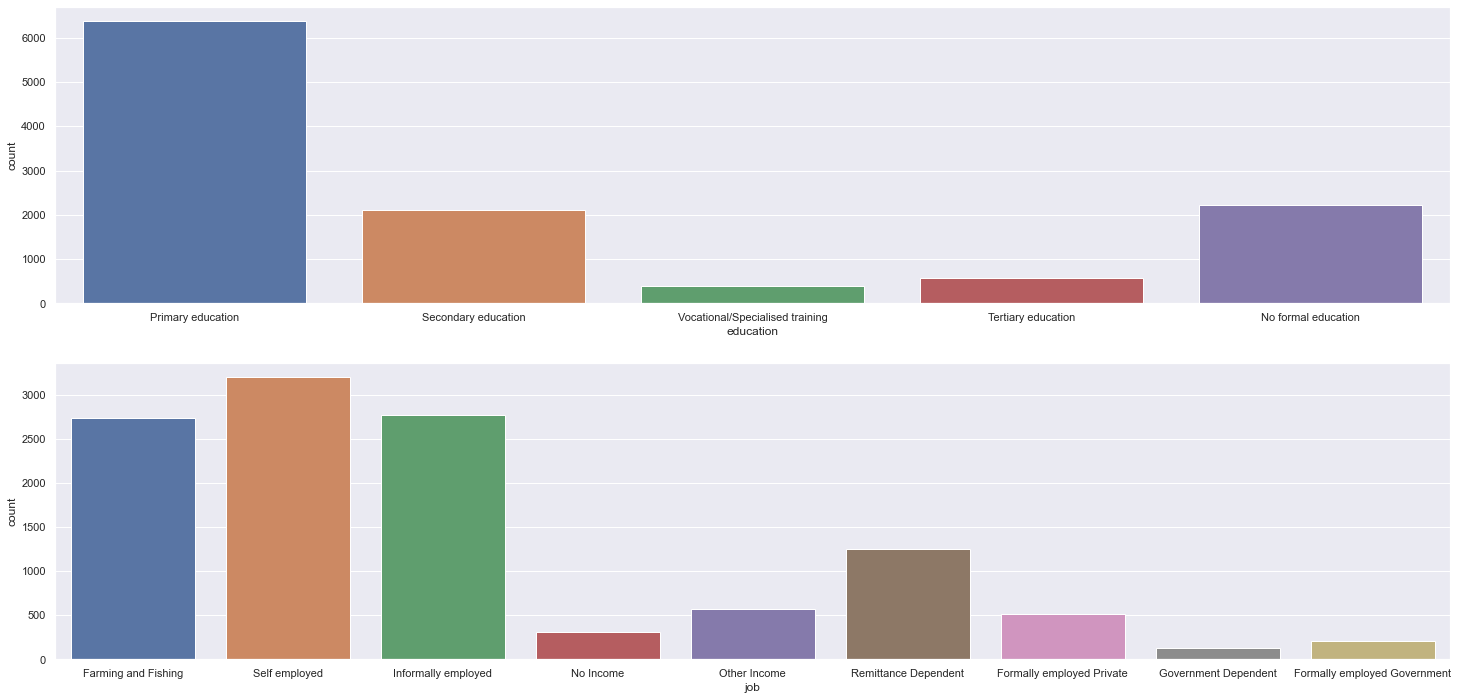

In [31]:
plt.subplot(2,1,1)
sns.countplot(df4['education'])

plt.subplot(2,1,2)
sns.countplot(df4['job']);

## 4.2. Análise Bivariada

### <b>H1. Homens abrem mais contas que as mulheres</b>
### ***Hipótese verdadeira*** - A diferença é de apenas 5% mas os homens correspondem a 41% do dataset

In [32]:
df4.columns
df4.sex.value_counts()

Female    6853
Male      4826
Name: sex, dtype: int64

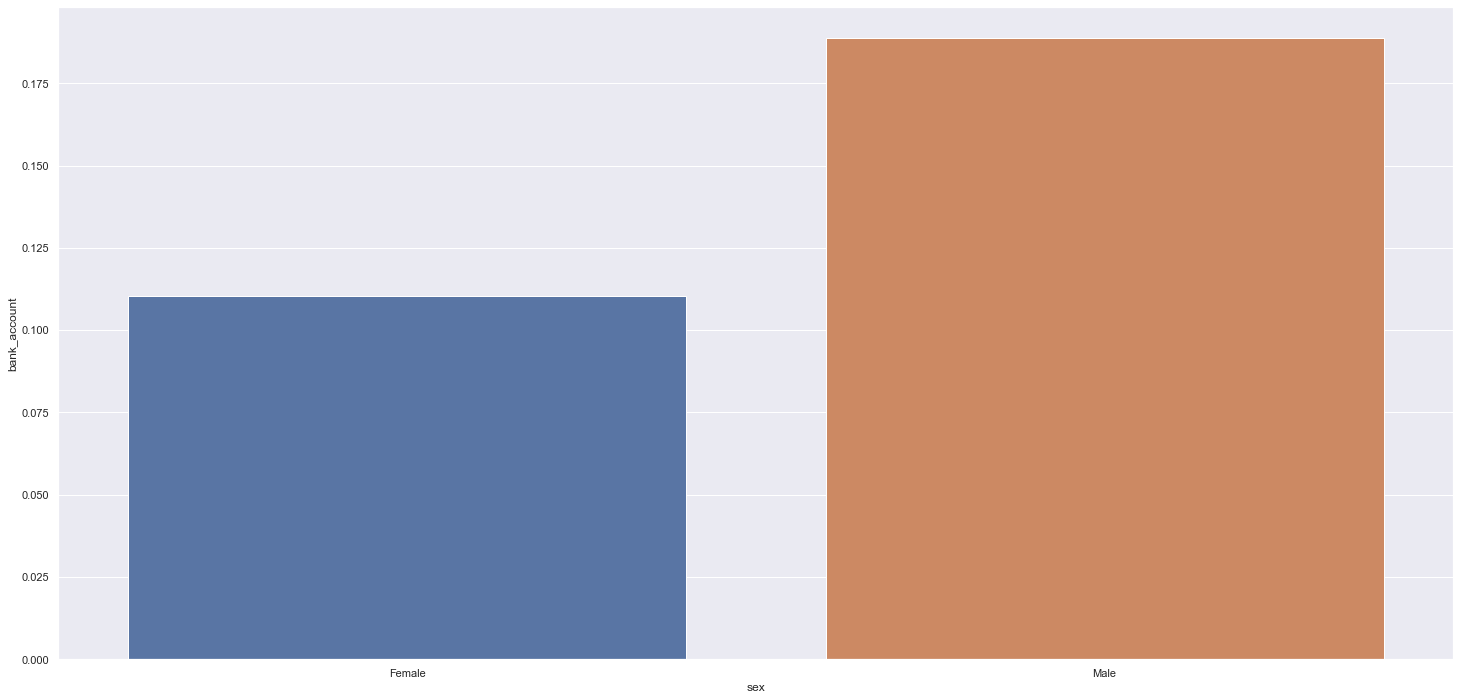

In [33]:
# Homens abrem mais contas que as mulheres
aux1 = df4[['sex', 'bank_account']].groupby('sex').mean().reset_index()
sns.barplot(x='sex', y='bank_account', data=aux1);

### <b>H2. Casados abrem mais contas que outros estados civis</b>
### ***Hipótese verdadeira*** - A diferença é bem significativa

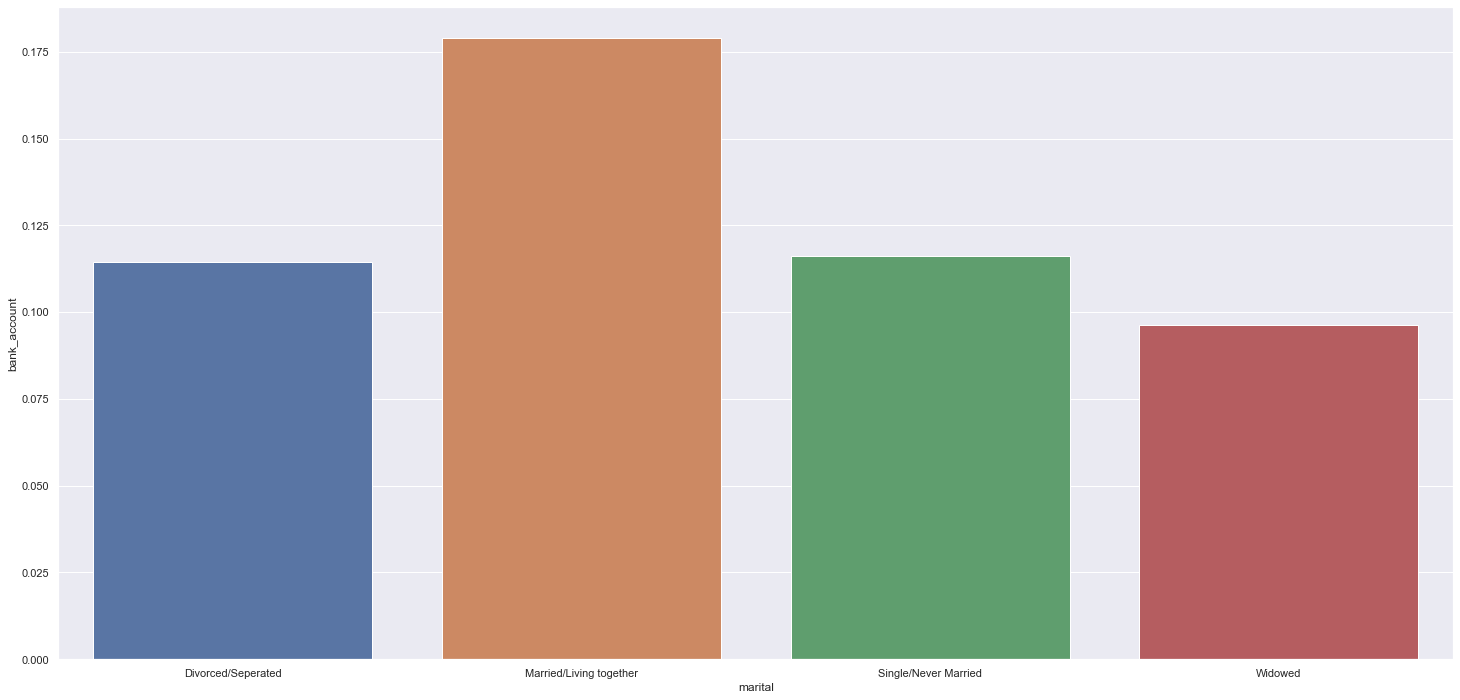

In [34]:
# Casados abrem mais contas que outros estados civis
aux1 = df4[['marital', 'bank_account']].groupby('marital').mean().reset_index()
sns.barplot(x='marital', y='bank_account', data=aux1);

### <b>H3. Pessoas com menos de 30 anos abrem menos contas</b>
### ***Hipótese falsa*** - A faixa etária de 25 a 30 é a que mais abre conta

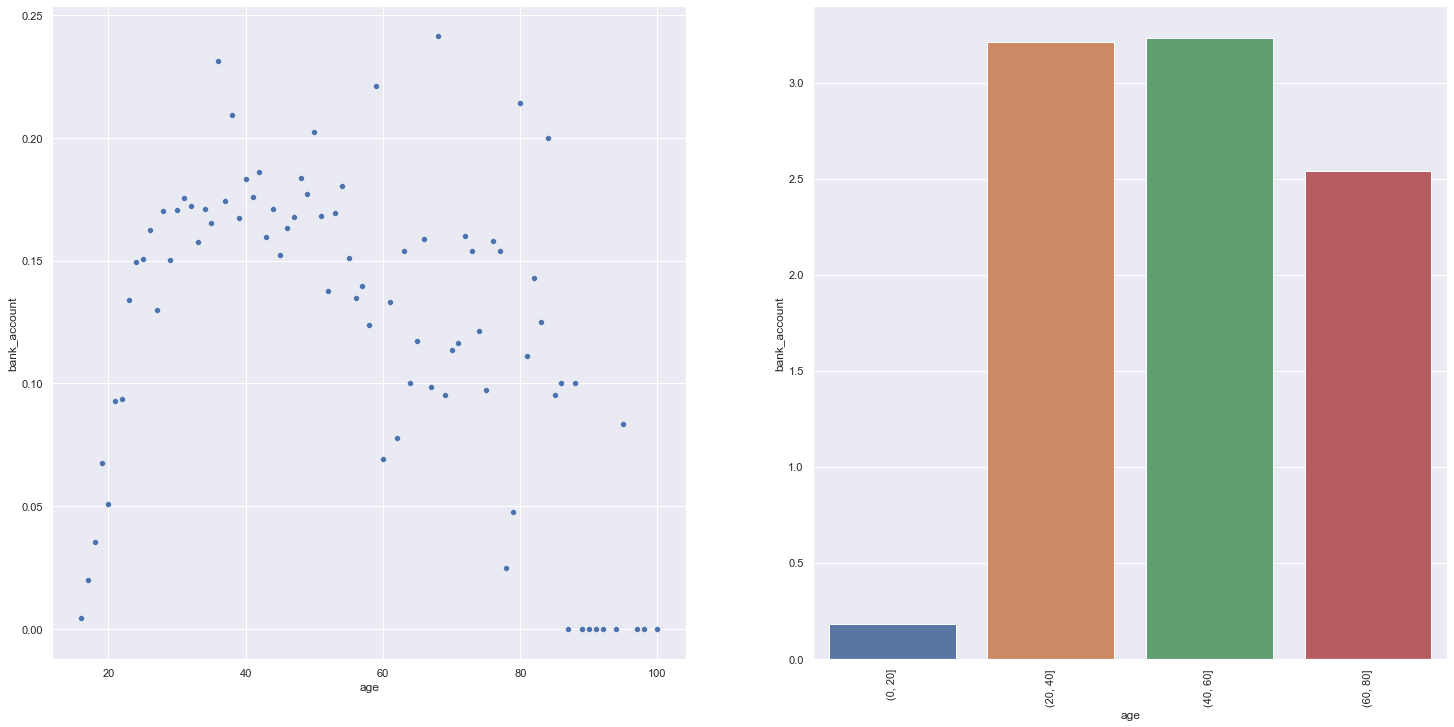

In [35]:
### 3. Pessoas com menos de 30 anos abrem menos contas
aux1 = df4[['age', 'bank_account']].groupby('age').mean().reset_index()

plt.subplot(1, 2, 1)
sns.scatterplot(data=aux1, x='age', y='bank_account');

plt.subplot(1, 2, 2)
# Criando os bins (níveis para o gráfico)
bins = np.arange(0, 100, 20)
# 'Cortando' a coluna nos tamenhos dos bins
aux1['age'] = pd.cut(aux1['age'], bins=bins)
aux2 = aux1[['age', 'bank_account']].groupby('age').sum().reset_index()
sns.barplot(data=aux2, x='age', y='bank_account',);
plt.xticks(rotation=90);

### <b>H4. Moradores da área rural abrem menos contas</b>
### ***HIPÓTESE Verdadeira*** - 

In [36]:
df4.location.value_counts()

Rural    7042
Urban    4637
Name: location, dtype: int64

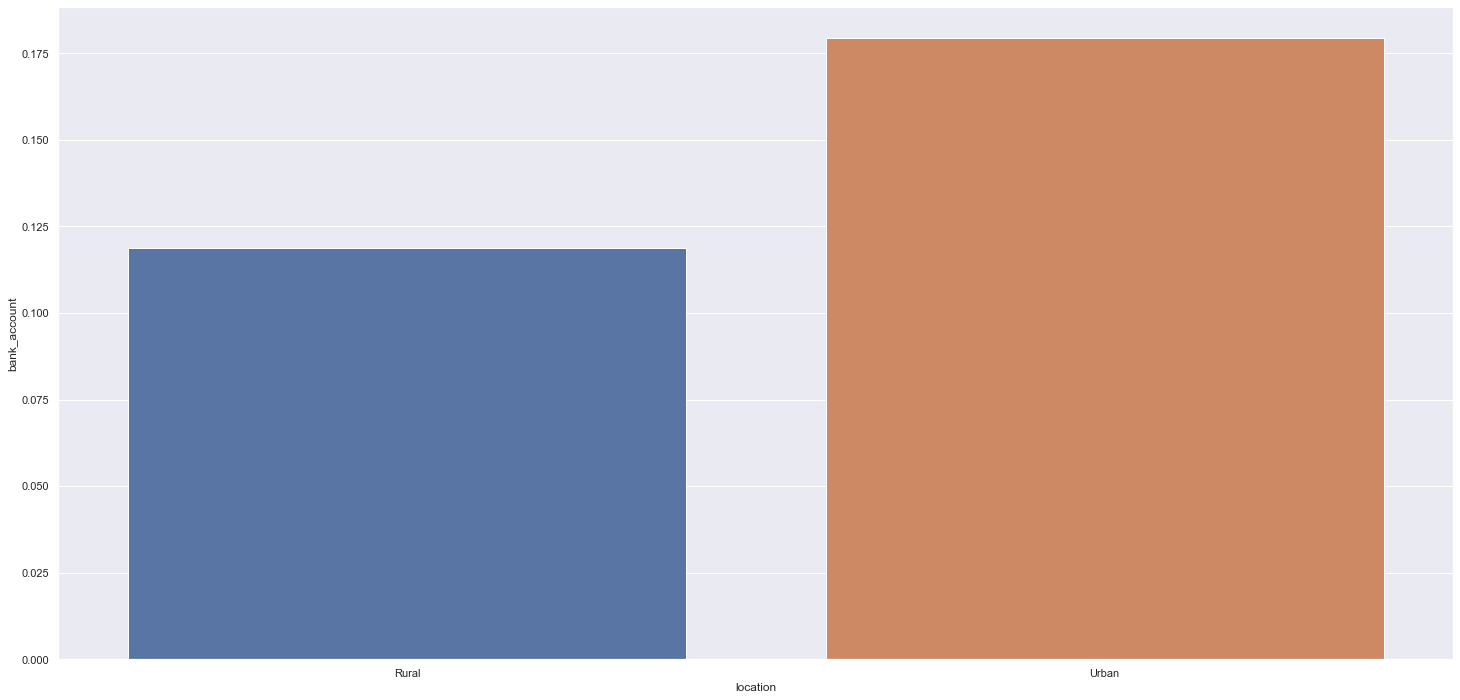

In [37]:
aux1 = df4[['location','bank_account']].groupby('location').mean().reset_index()
sns.barplot(x='location', y='bank_account', data=aux1);

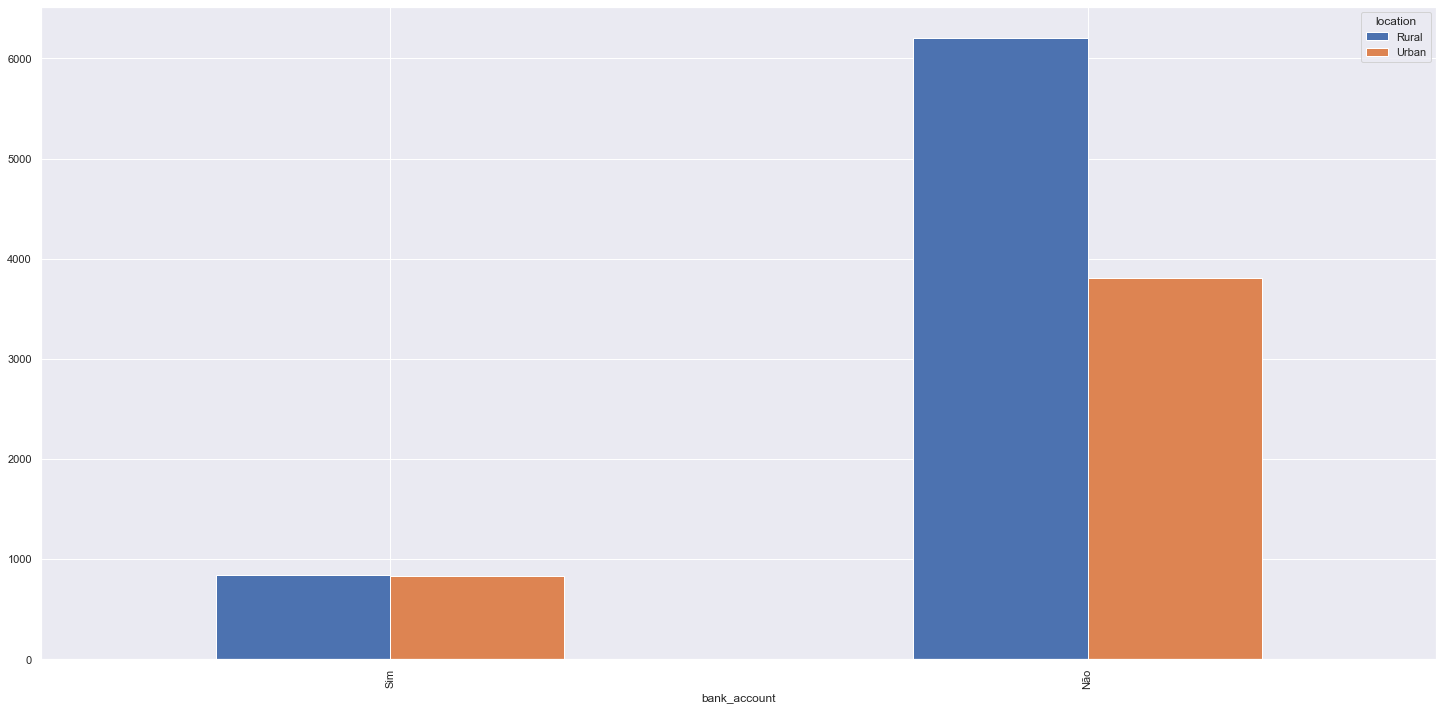

In [38]:
aux1 = df4.copy()
aux1['bank_account'] = df4['bank_account'].apply(lambda x: 'Sim' if x == 1 else 'Não')
ordem = ['Sim','Não'] 
aux1.groupby('location')['bank_account'].value_counts().unstack(0).loc[ordem].plot.bar();

### <b>H5. Países com menor PIB tem menos abertura de contas</b>
### ***HIPÓTESE Falsa*** - A ordem dos países é diferente do ranking do PIB

In [39]:
df4.country.value_counts()

Rwanda      4294
Tanzania    3286
Kenya       3044
Uganda      1055
Name: country, dtype: int64

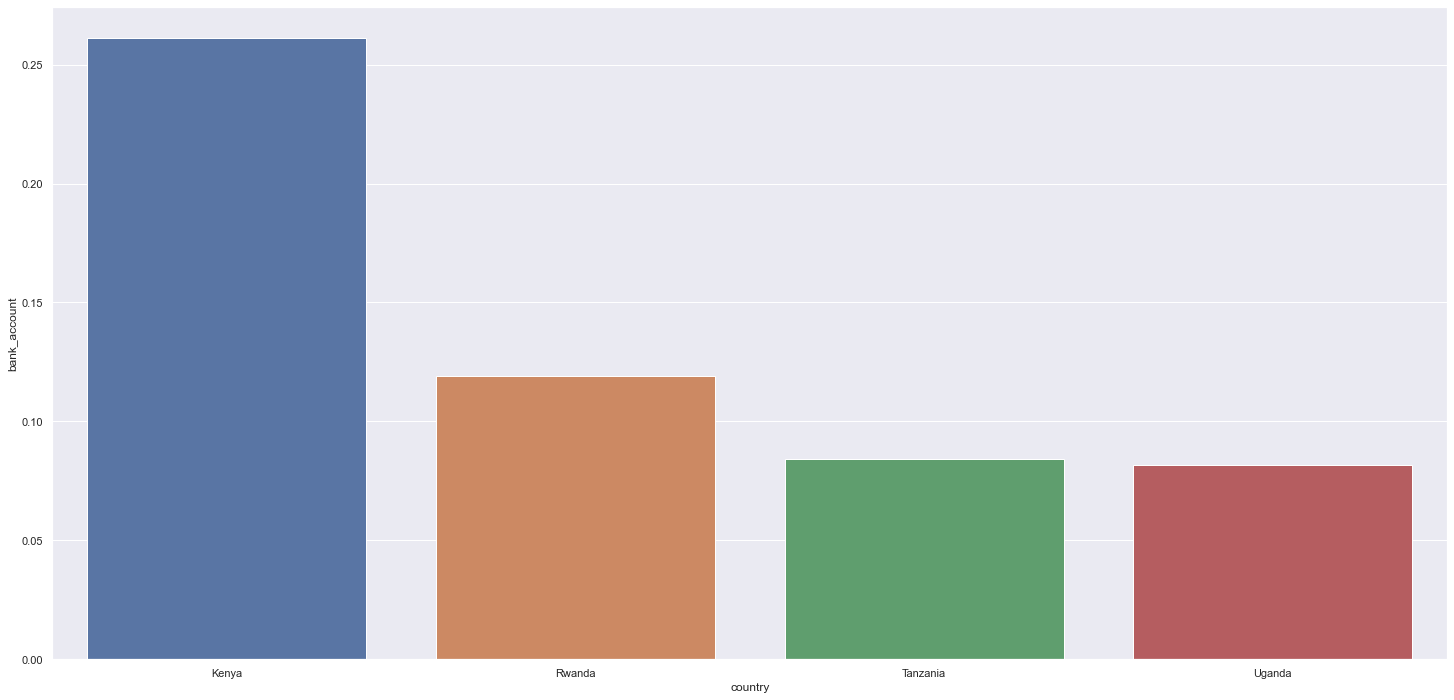

In [40]:
aux1 = df4[['country','bank_account']].groupby('country').mean().reset_index()
sns.barplot(x='country', y='bank_account', data=aux1);

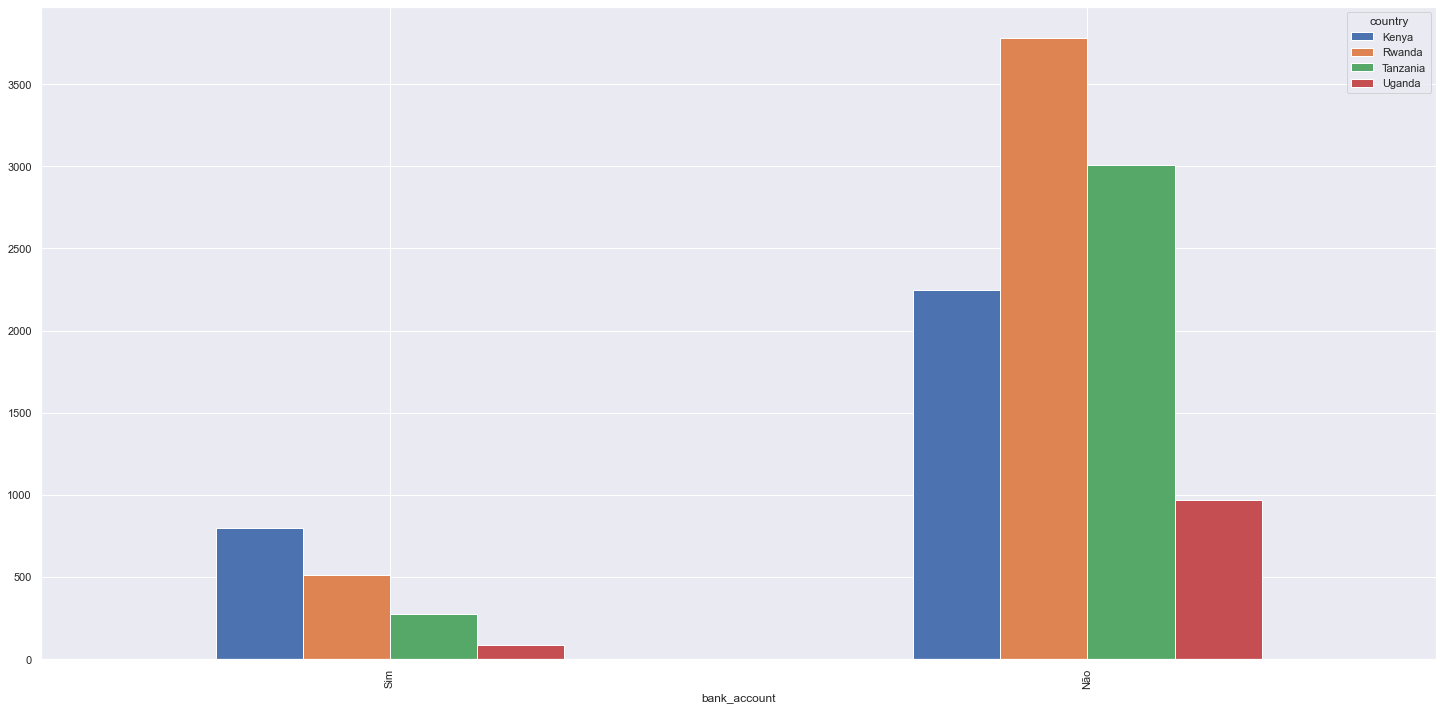

In [41]:
aux1 = df4.copy()
aux1['bank_account'] = df4['bank_account'].apply(lambda x: 'Sim' if x == 1 else 'Não')
ordem = ['Sim','Não'] 
aux1.groupby('country')['bank_account'].value_counts().unstack(0).loc[ordem].plot.bar();

'\nquenia 1169\ntanzania 900\nruanda 765\nuganda 666'

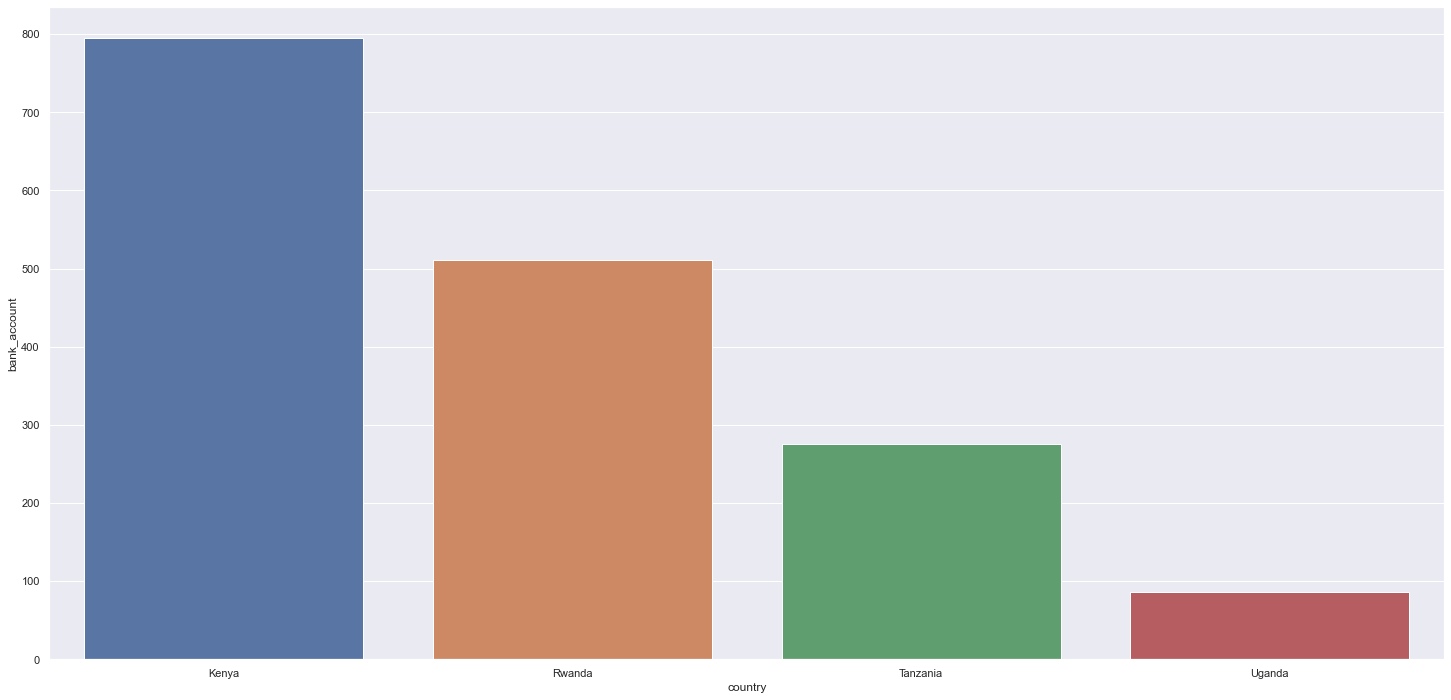

In [42]:
aux1 = df4[['country','bank_account']].groupby('country').sum().reset_index()
sns.barplot(data=aux1, x='country', y='bank_account',);

'''
quenia 1169
tanzania 900
ruanda 765
uganda 666'''

### <b>H6. Pessoas com acesso a telefonia móvel abrem mais contas</b>
### ***HIPÓTESE Verdadeira*** - resultado expressivo

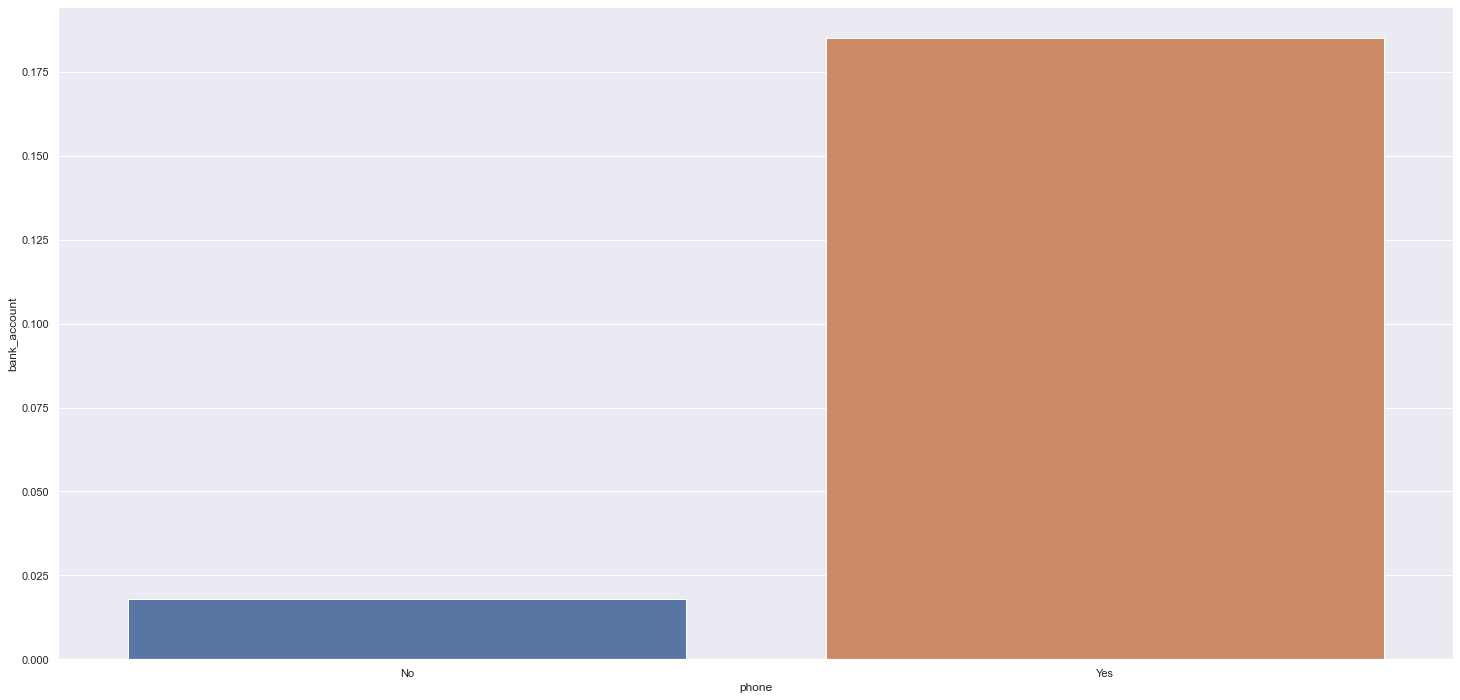

In [43]:
aux1 = df4[['phone', 'bank_account']].groupby('phone').mean().reset_index()
sns.barplot(x='phone', y='bank_account', data=aux1);

### <b>H7. Pessoas com maior instrução abrem mais contas</b>
### ***HIPÓTESE Verdadeira*** - resultado expressivo

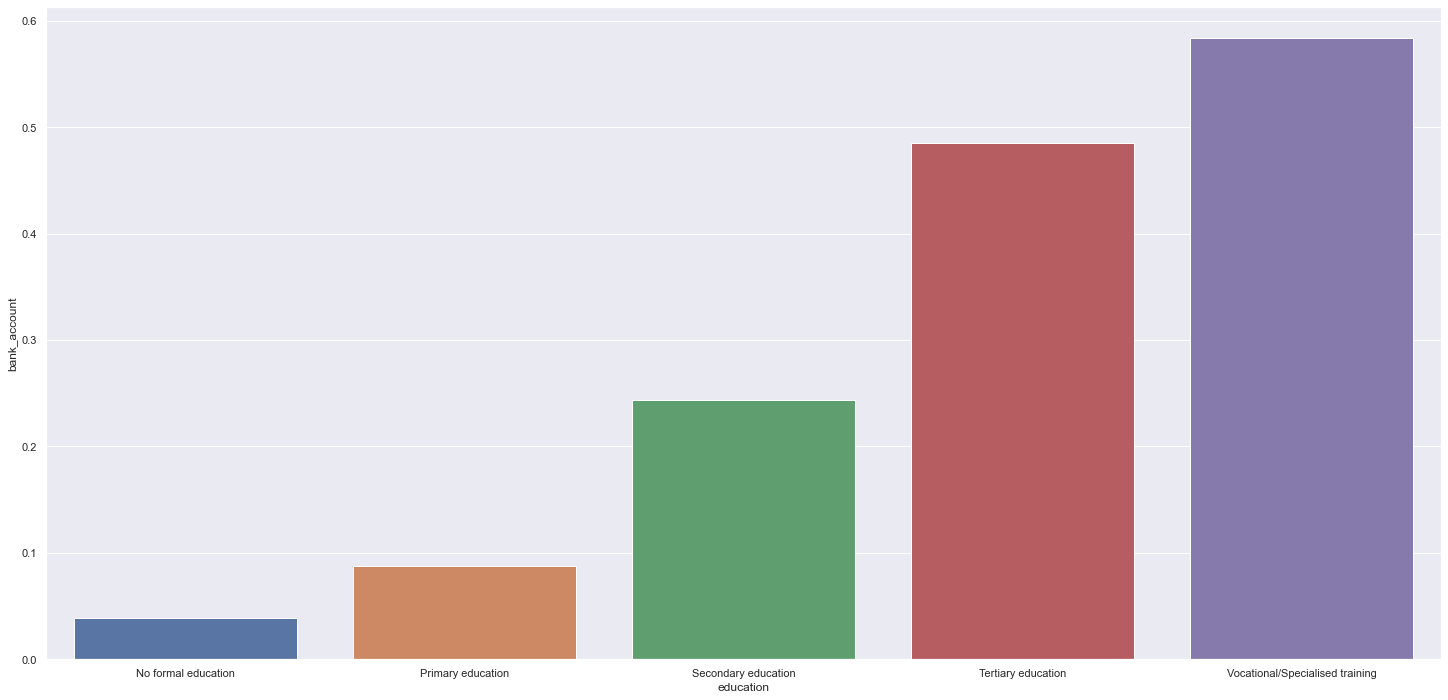

In [44]:
aux1 = df4[['education', 'bank_account']].groupby('education').mean().reset_index()
sns.barplot(x='education', y='bank_account', data=aux1);

### <b>H8. Pessoas com melhores condiçoes de trabalho abrem mais contas</b>
### ***HIPÓTESE Inconclusiva*** - 

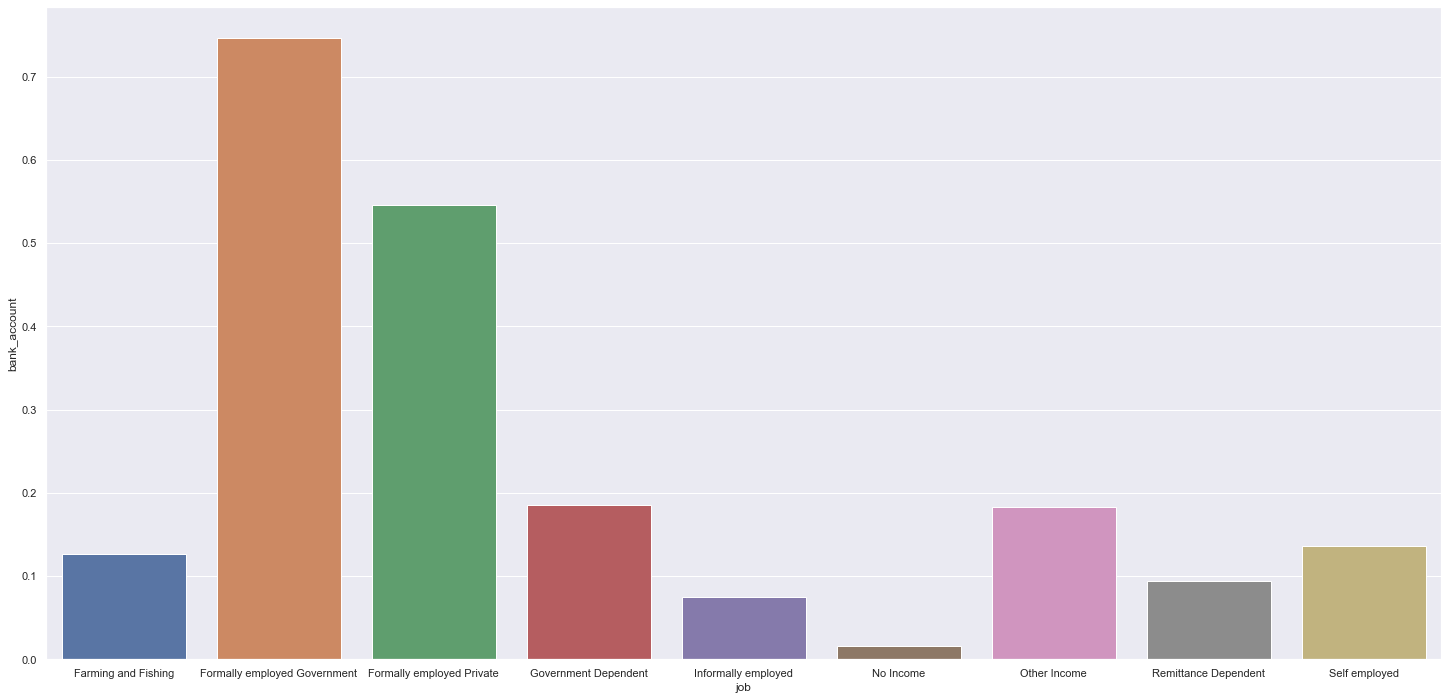

In [45]:
aux1 = df4[['job', 'bank_account']].groupby('job').mean().reset_index()
sns.barplot(x='job', y='bank_account', data=aux1);

### <b>H9. Chefes de familia abrem mais contas</b> Verdadeiro
### <b>H10. Filhos abrem menos contas</b> Verdadeiro
### <b>H11. Esposas abrem menos contas</b> Neutro

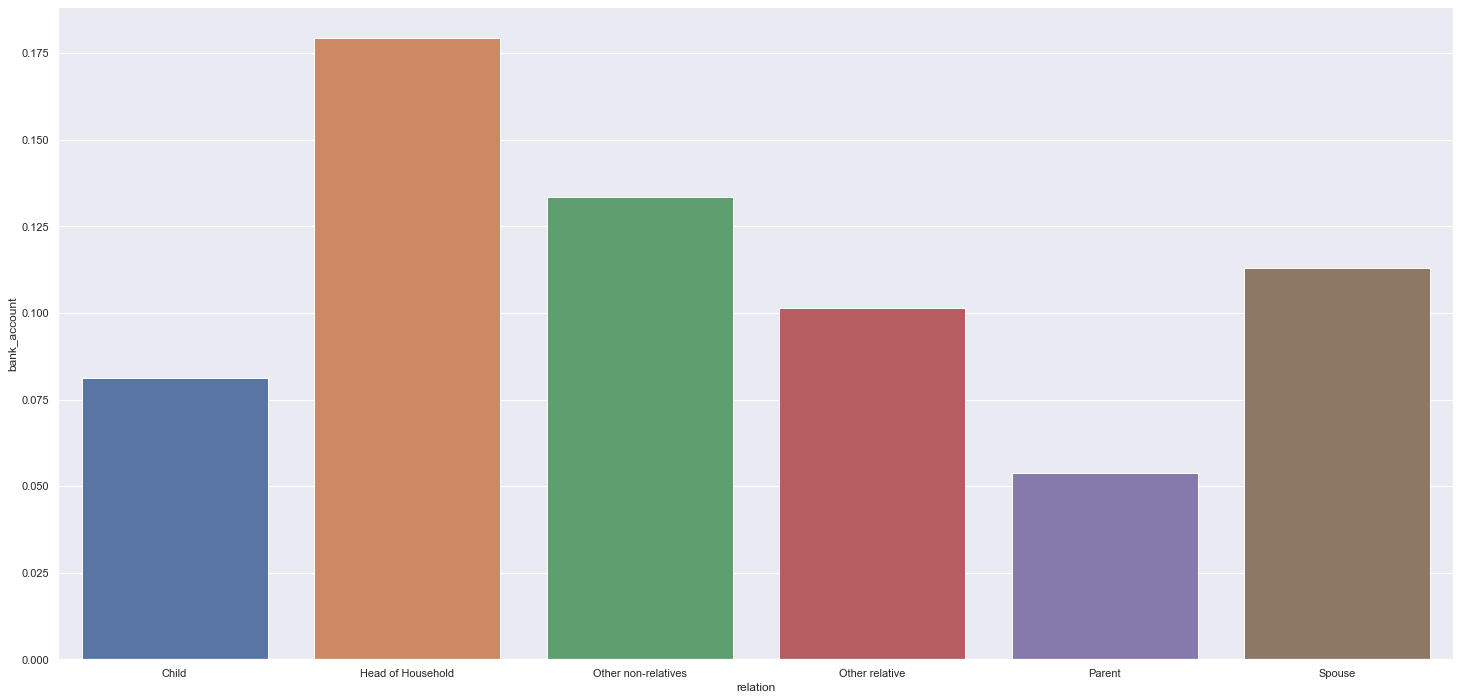

In [46]:
aux1 = df4[['relation', 'bank_account']].groupby('relation').mean().reset_index()
sns.barplot(x='relation', y='bank_account', data=aux1);

### <b>H12. Pessoas de familias maiores abrem menos contas</b>
### ***HIPÓTESE Falsa*** 

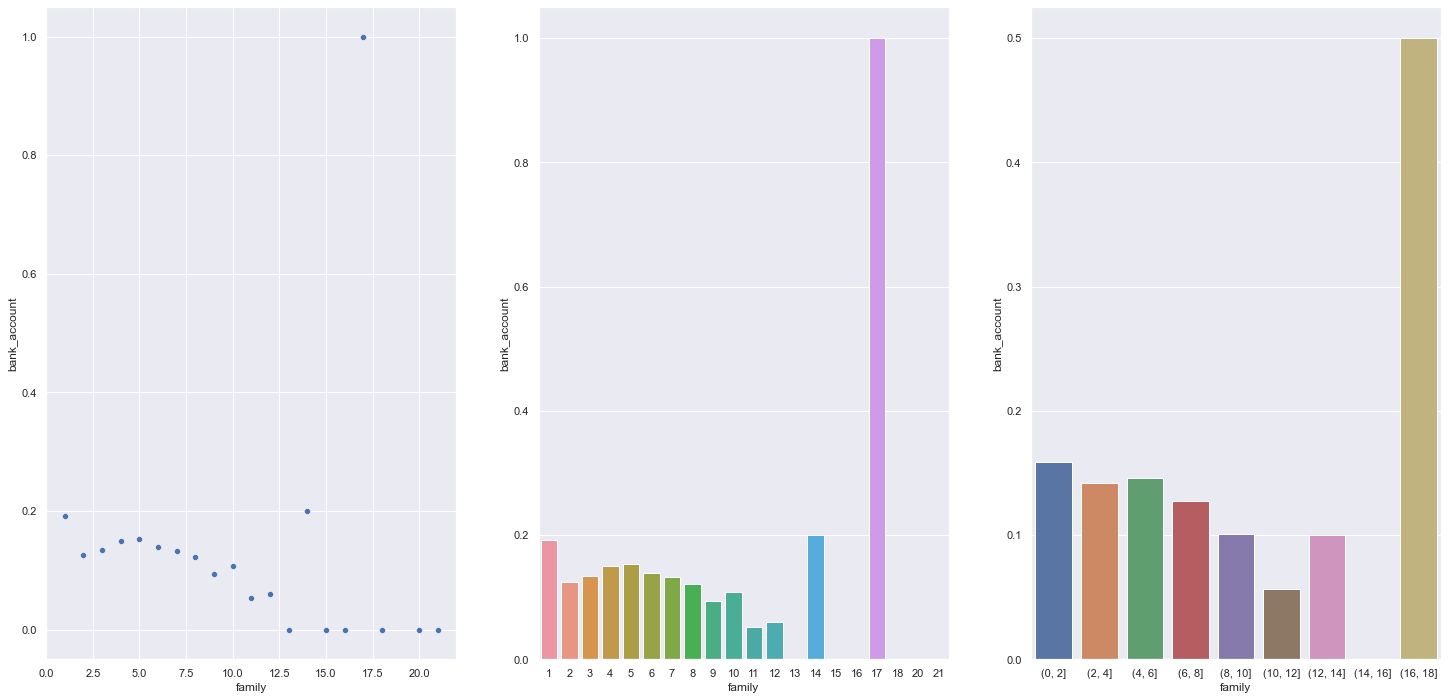

In [47]:
plt.subplot(1, 3, 1)
aux1 = df4[['family', 'bank_account']].groupby('family').mean().reset_index()
sns.scatterplot(data=aux1, x='family', y='bank_account');

plt.subplot(1, 3, 2)
# Criando os bins (níveis para o gráfico)
bins = np.arange(0, 20, 2)
sns.barplot(x='family', y='bank_account', data=aux1);

plt.subplot(1, 3, 3)
# 'Cortando' a coluna nos tamenhos dos bins
aux1['family'] = pd.cut(aux1['family'], bins=bins)
aux2 = aux1[['family', 'bank_account']].groupby('family').mean().reset_index()
sns.barplot(data=aux2, x='family', y='bank_account',);

### 4.2.1. Resumo das Hipoteses

In [48]:
tab =[
    ['Hipoteses', 'Conclusao', 'Relevancia'],
    ['H1', 'Verdadeira', 'Alta'],
    ['H2', 'Verdadeira', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Verdadeira', 'Media'],
    ['H5', 'Falsa', 'Baixa'],
    ['H6', 'Verdadeira', 'Alta'],
    ['H7', 'Verdadeira', 'Alta'],
    ['H8', 'Inconclusivo', 'Media'],
    ['H9', 'Verdadeira', 'Media'],
    ['H10', 'Verdadeira', 'Media'],
    ['H11', 'Verdadeira', 'Media'],
    ['H12', 'Falsa', 'Baixa'],   
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao     Relevancia
-----------  ------------  ------------
H1           Verdadeira    Alta
H2           Verdadeira    Media
H3           Falsa         Media
H4           Verdadeira    Media
H5           Falsa         Baixa
H6           Verdadeira    Alta
H7           Verdadeira    Alta
H8           Inconclusivo  Media
H9           Verdadeira    Media
H10          Verdadeira    Media
H11          Verdadeira    Media
H12          Falsa         Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

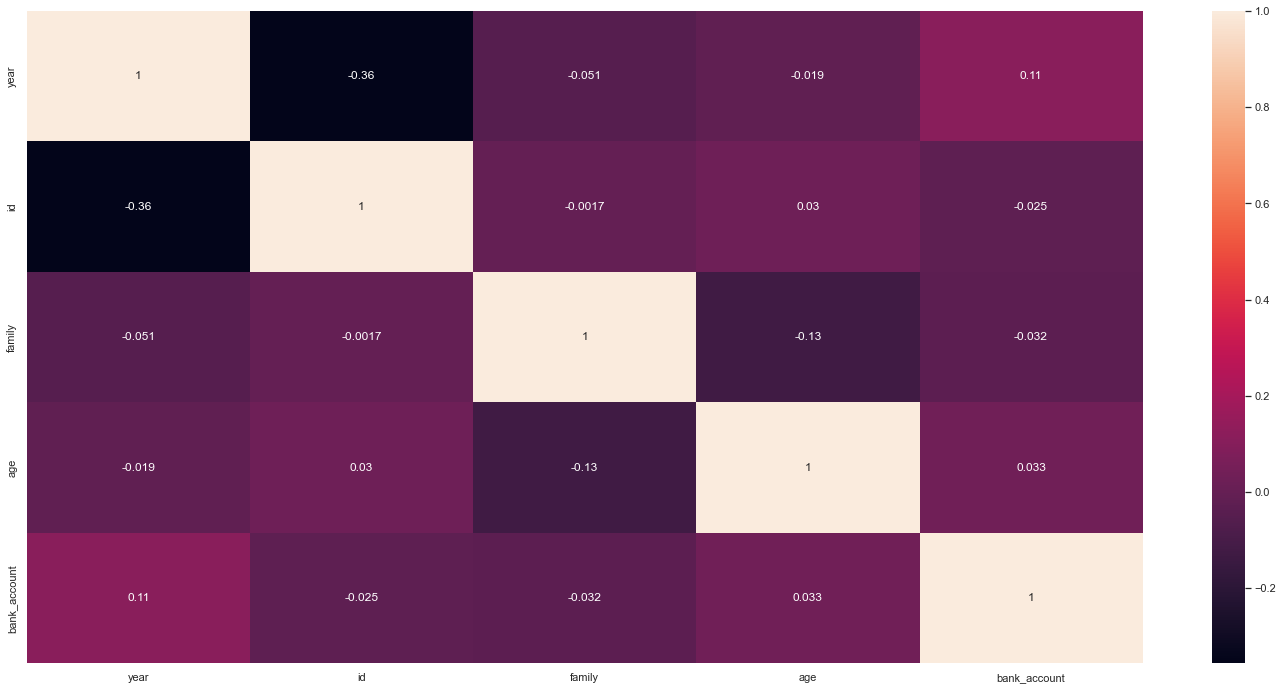

In [49]:
correlation = numerical_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 5.0. PASSO 5 - DATA PREPARATION

In [50]:
df5 = df4.copy()

## Split Dataframe into training and testing dataset

In [51]:
# Evitar vazamento?
aux1 = df5.drop(columns=['bank_account'])
X_train, X_test, y_train, y_test = train_test_split(
    aux1,
    df5['bank_account'],
    test_size=0.2,
    random_state=42)

## 5.1. Normalização

In [52]:
# Não temos variáveis com distribuição normal, logo não será aplicado a normalização
# Lembrando que para variáveis com distribuições não gaussianas aplica-se Rescaling

## 5.2. Rescaling

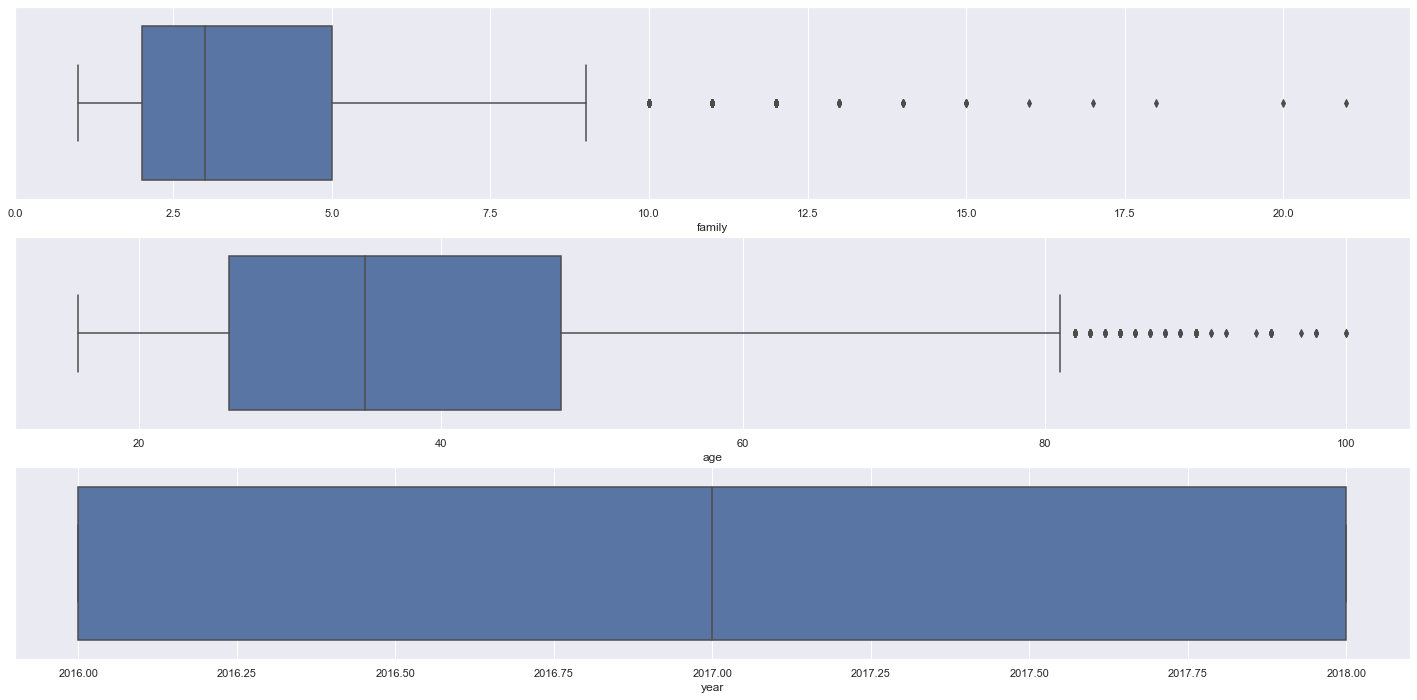

In [53]:
# Verificando se as features possuem muitos outliers

plt.subplot(3, 1, 1)
sns.boxplot(df5['family']);

plt.subplot(3, 1, 2)
sns.boxplot(df5['age']);

plt.subplot(3, 1, 3)
sns.boxplot(df5['year']);

In [54]:
# Fazendo o rescaling das features
ms = MinMaxScaler() # poucos outliers
rs = RobustScaler() # muitos outliers

df5['age'] = rs.fit_transform(df5[['age']].values)
df5['year'] = ms.fit_transform(df5[['year']].values)
df5['family'] = rs.fit_transform(df5[['family']].values)

## 5.3. Transformação

### <b>5.3.1. Encoding</b>

In [55]:
# Aplicando o One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['sex'], columns=['sex'])
df5 = pd.get_dummies(df5, prefix=['phone'], columns=['phone'])
df5 = pd.get_dummies(df5, prefix=['location'], columns=['location'])

# store_type - Aplicando o Label Encoding
le = LabelEncoder()
df5['job'] = le.fit_transform(df5['job'])
df5['country'] = le.fit_transform(df5['country'])
df5['marital'] = le.fit_transform(df5['marital'])
df5['relation'] = le.fit_transform(df5['relation'])

# Aplicando o Ordinal Encoding
education_dict = {
    'No formal education':1, 
    'Primary education' : 2, 
    'Secondary education' : 3, 
    'Vocational/Specialised training':4, 
    'Tertiary education' : 5}
df5['education'] = df5['education'].map(education_dict)

### <b>5.3.2. Response Variable Transformation</b>

In [56]:
# Transformação da variável resposta, 

### <b>5.3.2. Nature Transformation</b>

# 6.0. PASSO 6 - FEATURE SELECTION

In [57]:
df6 = df5.copy()

## 6.1. Split Dataframe into training and testing dataset

In [58]:
# Deletar as colunas que derivaram outras e perderam a utilidade
cols_drop = []
df6 = df6.drop(cols_drop, axis=1)

In [59]:
# Evitar vazamento?
aux1 = df5.drop(columns=['bank_account'])
X_train, X_test, y_train, y_test = train_test_split(
    aux1,
    df5['bank_account'],
    test_size=0.2,
    random_state=42)

## 6.2. Boruta as Feature Selector

In [63]:
# O Boruta não recebe como parâmetro um df e sim um numpy.array
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# Define o Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	12
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	12
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	12
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	12
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	12
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	12
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	12
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	12
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	12
I

### **6.2.1. Best Features From Boruta**

In [64]:
# Armazena os índices das colunas selecionadas e ranqueadas pelo Boruta
cols_selected = boruta.support_.tolist()

X_train_fs = X_train.copy()

# Colunas selecionadas pelo Boruta
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Colunas não selecionadas pelo Boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [65]:
print(f'Colunas selecionadas pelo Boruta: {cols_selected_boruta}')
print(f'Colunas Não selecionadas pelo Boruta: {cols_not_selected_boruta}')

Colunas selecionadas pelo Boruta: ['age', 'education']
Colunas Não selecionadas pelo Boruta: ['country', 'family', 'id', 'job', 'location_Rural', 'location_Urban', 'marital', 'phone_No', 'phone_Yes', 'relation', 'sex_Female', 'sex_Male', 'year']


## 6.3. Manual Feature Selection
### **Comparar as sugestões do Boruta com as conclusões das hipóteses e decidir quais entrarão no modelo, lembrando que por ser o CRISP pode utilizar a sugestão do Boruta nessa iteração e na próxima.**

In [67]:
# Célula criada para não ser necessário rodar o Boruta para cada
# iteração do notebook, equivale a seleção manual de features. 
# Foram acrescentadas algumas features que o Boruta deixou de fora.

# Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(cols_not_selected_boruta)
cols_selected_boruta_full

['age',
 'education',
 'country',
 'family',
 'id',
 'job',
 'location_Rural',
 'location_Urban',
 'marital',
 'phone_No',
 'phone_Yes',
 'relation',
 'sex_Female',
 'sex_Male',
 'year']

# 7.0. PASSO 7 - MACHINE LEARNING MODELLING

In [68]:
df7 = df6.copy()

In [83]:
# Criando os datasets de treino e teste com as features selecionadas no passo anterior (Boruta)
X_train = X_train[cols_selected_boruta_full]
X_test = X_test[cols_selected_boruta_full]

In [164]:
f1_default = list()
f1_crossval = list()
f1_voting = list()
model_name = ['Logistic Regression', 'Random Forest', 'XGBoost', 'AdaBoost']

In [165]:
def best_parameter(model, model_name, params, x, y):
    ''' 
    Recebe um modelo, uma lista de parâmetros, os dados para treino, treina 
    o modelo usando GridSearch para selecionar os melhores parâmetros.    
    '''
    # Init Grid Search
    grid_cv = GridSearchCV(model, param_grid=params, n_jobs=1, cv=10, scoring="f1")

    # Fit
    _ = grid_cv.fit(x, y)

    # Imprime os melhores parâmetros do modelo
    print(f'Melhores parâmetros para {model_name}: {grid_cv.best_params_}\n')

    # Imprime o resultado do modelo treinado com os melhores parâmetros
    return grid_cv.best_score_.round(3)

## 7.1. Logistic Regression Model

In [166]:
logistic = LogisticRegression(random_state=0, solver='liblinear')

# Fit
logistic.fit(X_train, y_train)

# Predict
preds = logistic.predict(X_test)

# Score
logistic_f1 = f1_score(y_test, preds)
f1_default.append(logistic_f1)
logistic_f1

0.3774403470715835

## 7.2. Random Forest Classifier Model

In [198]:
r_forest = RandomForestClassifier(random_state=0)

# Fit
r_forest.fit(X_train, y_train)

# Predict
preds = r_forest.predict(X_test)

# Score
rf_f1 = f1_score(y_test, preds)
f1_default.append(rf_f1)
rf_f1

0.4356060606060606

## 7.3. XGBoost Classifier Model

In [199]:
xgboost = xgb.XGBClassifier(
    n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
    learning_rate=0.2, max_depth=10, subsample=0.9, colsample_bytree=0.9
)

# Fit
xgboost.fit(X_train, y_train)

# Predict
preds = xgboost.predict(X_test)

# Score
xgb_f1 = f1_score(y_test, preds)
f1_default.append(xgb_f1)
xgb_f1

0.45054945054945056

## 7.4. AdaBoost Classifier Model

In [200]:
adaboost = AdaBoostClassifier(n_estimators=100)

# Fit
adaboost.fit(X_train, y_train)

# Predict
preds = xgboost.predict(X_test)

# Score
ada_f1 = f1_score(y_test, preds)
f1_default.append(ada_f1)
ada_f1

0.45054945054945056

## 7.5. Majority Class Labels

In [201]:
eclf = VotingClassifier(
     estimators=[('log_r', logistic), ('rf', r_forest), ('xgb', xgboost), ('ada', adaboost)],
     voting='hard')

for clf, label in zip(
    [logistic, r_forest, xgboost, adaboost, eclf], 
    ['Logistic Regression', 'Random Forest', 'XGBoost', 'AdaBoost']):
     scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10)
     f1_voting.append(scores.mean())
     print("F1 score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


F1 score: 0.36 (+/- 0.04) [Logistic Regression]
F1 score: 0.43 (+/- 0.04) [Random Forest]


KeyboardInterrupt: 

In [ ]:
# LogisticRegression
params = {'C': np.logspace(-5, -1, 2, 15, 25)}
f1_crossval.append(best_parameter(logistic, 'Logitic Regression', params, X_train, y_train))

# RandomForestClassifier 
params = {
    'max_depth': [2,5,10,50,100],
    'max_leaf_nodes': [5,25,50],
    'min_samples_leaf': [5,10,100,500],
    'n_estimators': [100,200,500],
}

f1_crossval.append(best_parameter(r_forest, 'Random Forest', params, X_train, y_train))

# Xgboost
params = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}
f1_crossval.append(best_parameter(xgboost, 'XGBoost', params, X_train, y_train))


# AdaBoostClassifier
params = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [1, 3, 5, 10],    
}
f1_crossval.append( best_parameter(adaboost, 'AdaBoost', params, X_train, y_train) )


Melhores parâmetros para Logitic Regression: {'C': 0.04}

Melhores parâmetros para Random Forest: {'max_depth': 10, 'max_leaf_nodes': 50, 'min_samples_leaf': 5, 'n_estimators': 100}

Melhores parâmetros para XGBoost: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1, 'scale_pos_weight': 3, 'subsample': 0.8}

Melhores parâmetros para AdaBoost: {'learning_rate': 1, 'n_estimators': 200}



In [ ]:
f1_table = pd.DataFrame({
    'Model': model_name,
    'f1_default': f1_default,
    'f1_voting': f1_voting,
    'f1_table': f1_crossval
})

In [ ]:
f1_table.head()

Model  f1_default  f1_voting  f1_table
0  Logistic Regression    0.377440   0.356024     0.334
1        Random Forest    0.435606   0.427133     0.391
2              XGBoost    0.450549   0.471926     0.562
3             AdaBoost    0.450549   0.467456     0.466

In [228]:
import re

df = pd.DataFrame(data = {'Renda':[' o valor 200 e 300', 'o valor e 301 e 400', 'o valor e ate 200']}, index=[1,2,3])

def get_renda(string):
    output = []
    txt = string.split()
    p = '[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+'
    for word in txt:
        match = re.search(p, word)
        if match:
            output.append(match.group())
    return output
    
df['valor_inicial'] = df['Renda'].apply(lambda x: 0 if len(get_renda(x)) < 2 else get_renda(x)[0] )
df['valor_final'] = df['Renda'].apply(lambda x: get_renda(x)[0] if len(get_renda(x)) < 2 else get_renda(x)[1])
df

Renda valor_inicial valor_final
1    o valor 200 e 300           200         300
2  o valor e 301 e 400           301         400
3    o valor e ate 200             0         200

In [ ]:
teto_superior(a)
a = 'entre R$ 3921,00 e 7419,00'


In [72]:
params = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [73]:
# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid=params, n_jobs=1, cv=3, scoring="f1")

# Fit
_ = grid_cv.fit(X_train, y_train)

In [74]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 7,
 'reg_lambda': 1,
 'scale_pos_weight': 3,
 'subsample': 0.8}

In [75]:
grid_cv.best_score_

0.5653186847436497

In [ ]:
params = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

def best_parameter(model, model_name, params, x, y):
    ''' 
    Recebe um modelo, uma lista de parâmetros, os dados para treino, treina 
    o modelo usando GridSearch para selecionar os melhores parâmetros.    
    '''
    # Init Grid Search
    grid_cv = GridSearchCV(model, param_grid=params, n_jobs=1, cv=3, scoring="f1")

    # Fit
    _ = grid_cv.fit(x, y)

    # Imprime os melhores parâmetros do modelo
    print(grid_cv.best_params_)

    # Imprime o resultado do modelo treinado com os melhores parâmetros
    print(grid_cv.best_score_)

## 7.5. XGBoost Regressor

In [76]:
# Criando o modelo XGBoost
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    # eta=0.03,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.9).fit(x_train, y_train)

# Fazendo a predição
y_hat_xgb = model_xgb.predict(x_test)

# Conhecendo a performance do modelo
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(y_hat_xgb))
xgb_result

NameError: name 'ml_error' is not defined

### **7.5.1. XGBoost - Cross Validation**

In [ ]:
# xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
# xgb_result_cv

## 7.6. Compare Model's Perfomance

### ***7.6.1. Single Performance***

In [ ]:
# Comparando as perfomances dos modelos
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

Model Name     MAE  MAPE    RMSE
0              XGBoost Regressor  687.46  0.10  997.97
0                  Random Forest  679.69  0.10 1010.61
0                  Average Model 1354.80  0.46 1835.14
0              Linear Regression 1867.09  0.29 2671.05
0  Linear Regression Regularized 1891.70  0.29 2744.45

### ***7.6.2. Real Performance - Cross Validation***

In [ ]:
# # Comparando as perfomances dos modelos
# modeling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
# modeling_result_cv.sort_values('RMSE')